In [2]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
#from mpl_toolkits.basemap import Basemap
#import matplotlib.pyplot as plt

In [3]:
client = bigquery.Client.from_service_account_json("../../airqo-250220-c81b55f1dc21.json")

In [4]:
def get_static_channels():

    sql = """
        SELECT channel_id 
        FROM `airqo-250220.thingspeak.channel` 
        WHERE NOT LOWER(name) LIKE '%mobile%' 
        LIMIT 1000
    """

    channels = [channel.channel_id for channel in client.query(sql).result()]

    return channels

In [5]:
channels = get_static_channels()
channels[0:5]

[930426, 912220, 912223, 912222, 930427]

In [6]:
def get_df(channel_id):
    sql = """
    SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE channel_id={}
    """.format(channel_id)

    df = client.query(sql).to_dataframe()
    return df

In [7]:
def get_loc():
    sql = """
    SELECT channel_id, longitude, latitude 
    FROM `airqo-250220.thingspeak.channel`
    """

    df = client.query(sql).to_dataframe()
    
    return df

In [8]:
locs = get_loc()
locs

,channel_id,longitude,latitude
0,930426,32.646800,0.365500
1,912220,32.576000,0.322108
2,912223,32.635306,0.341674
3,912222,32.632288,0.325346
4,930427,32.588000,0.268900
...,...,...,...
72,755610,0.000000,0.000000
73,689530,34.233700,1.084000
74,689766,29.701400,-1.283200
75,689522,33.817200,0.201900


In [9]:
locs = locs.replace(0, np.nan)
locs = locs.dropna().reset_index().drop('index', axis=1)

In [19]:
locs

,channel_id,longitude,latitude,pm2.5
0,930426,32.646800,0.365500,2.000999
1,912220,32.576000,0.322108,1.521366
2,912223,32.635306,0.341674,1.787731
3,912222,32.632288,0.325346,2.172990
4,930427,32.588000,0.268900,2.588856
...,...,...,...,...
57,689759,33.623900,0.777000,1.451645
58,689530,34.233700,1.084000,2.153233
59,689766,29.701400,-1.283200,2.693116
60,689522,33.817200,0.201900,2.692112


In [40]:
locs["longitude"][1]

32.576

In [18]:
locs["pm2.5"] = np.random.uniform(1,3,62)

(0, 0.5)

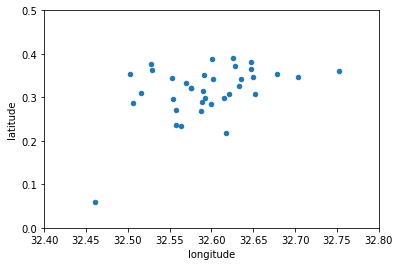

In [33]:
ax = locs.plot(kind="scatter", x="longitude", y="latitude")
ax.set_xlim(32.4, 32.8)
ax.set_ylim(0,0.5)

In [36]:
xgrid = np.linspace(32.4, 32.8, 10)
ygrid = np.linspace(0, 0.5, 10)

In [46]:
def sensor_distance(x1,y1,x2,y2):
    dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

In [47]:
distance = []
for x in xgrid:
    for y in ygrid:
        for i in range(len(locs)):
            distance.append(sensor_distance(x,y,locs["longitude"][i],locs["latitude"][i])) 

In [48]:
distance

[0.441022096952069,
 0.3670552596871494,
 0.4148614659280862,
 0.3997595960824479,
 0.32810243827195323,
 0.451944922954115,
 0.46044900912044595,
 0.36709763333478423,
 0.30560659265467477,
 0.45461738858077305,
 0.39709546711087,
 0.38524018481980987,
 0.43735437576409414,
 0.3969276508382878,
 2.7132971897674594,
 0.42732816429531145,
 2.3800390248901384,
 2.1049559829127085,
 2.30837293780706,
 0.33108610662484755,
 0.31283222340417616,
 0.39651158873354414,
 1.2323595092342172,
 2.0643590046307394,
 2.3231292882661507,
 0.28353527117450605,
 0.28513367040740684,
 2.2314944588772763,
 1.757741633460394,
 0.4365286359449976,
 0.9184710120629849,
 0.36811199382796733,
 0.35533786738820855,
 2.1799217600638827,
 0.08478354793236575,
 1.7319662150284612,
 0.3694482913751264,
 0.7150518372817455,
 0.37316930473982013,
 0.308157427299752,
 2.498648996958155,
 0.37844498939740506,
 0.4506172211533859,
 0.5044833000209241,
 2.1694055522193203,
 0.5371976638072788,
 0.7297315739366093,
 0.3

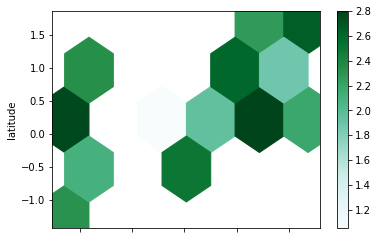

In [29]:
ax = locs.plot.hexbin(x="longitude", y="latitude",C="pm2.5",gridsize=5)

In [11]:
def get_last_entry(channel_id):
    sql = """
    SELECT created_at, channel_id, pm2_5 
    FROM `airqo-250220.thingspeak.clean_feeds_pms` 
    WHERE channel_id={} 
    ORDER BY created_at DESC 
    LIMIT 1
    """.format(channel_id)

    df = client.query(sql).to_dataframe() 
    
    return df

In [12]:
data = pd.DataFrame()
for channel in channels[0:5]:
    data = data.append(get_last_entry(channel))

In [13]:
data

,created_at,channel_id,pm2_5
0,2020-03-20 06:04:13,930426,34.78
0,2020-03-20 06:04:00,912220,29.10
0,2020-03-20 06:03:34,912223,9.48
0,2020-03-20 06:04:02,912222,23.23
0,2020-03-19 14:58:40,930427,25.58


In [14]:
def model(data):
    return data["pm2_5"].mean()

In [15]:
model(data)

24.434

In [16]:
map = Basemap()

map.drawcoastlines()

plt.show()

NameError: name 'Basemap' is not defined